In [22]:
import json
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

    # Load the JSON data
with open('C:/Users/alzae/OneDrive/Desktop/meme-captioning/memes-trainval.json', 'r') as f:
        train_data = json.load(f)

with open('C:/Users/alzae/OneDrive/Desktop/meme-captioning/mlr_captioning_TEST.json', 'r') as f:
        test_data = json.load(f)

    # Data paths
image_dir = 'C:/Users/alzae/OneDrive/Desktop/meme-captioning/memes'
    
    # Prepare dataframes
def json_to_dataframe(data):
    rows = []
    for entry in data:
        row = {
            "post_id": entry["post_id"],  # Include post_id from the JSON data
            "img_fname": entry["img_fname"],
            "img_captions": " ".join(entry["img_captions"]),
            "meme_captions": " ".join(entry["meme_captions"]) if "meme_captions" in entry else None
        }
        rows.append(row)
    return pd.DataFrame(rows)

train_df = json_to_dataframe(train_data)
test_df = json_to_dataframe(test_data)

    # Preprocess images with error handling
def preprocess_image(img_path):
        try:
            img = Image.open(img_path).resize((224, 224)).convert('RGB')  # Ensure image is in RGB format
            img = np.array(img) / 255.0
            return img
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            return np.zeros((224, 224, 3))  # Return a zero array for problematic images

train_df['img'] = train_df['img_fname'].apply(lambda x: preprocess_image(os.path.join(image_dir, x)))
test_df['img'] = test_df['img_fname'].apply(lambda x: preprocess_image(os.path.join(image_dir, x)))

    # Ensure all images are of shape (224, 224, 3)
assert all([img.shape == (224, 224, 3) for img in train_df['img']]), "Some images in training set have incorrect shape"
assert all([img.shape == (224, 224, 3) for img in test_df['img']]), "Some images in test set have incorrect shape"

    # Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['img_captions'].tolist() + train_df['meme_captions'].tolist())

max_length = max([len(txt.split()) for txt in train_df['img_captions'].tolist() + train_df['meme_captions'].tolist()])

def preprocess_text(text):
        sequences = tokenizer.texts_to_sequences([text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
        return padded_sequences[0]

train_df['img_captions_seq'] = train_df['img_captions'].apply(preprocess_text)
train_df['meme_captions_seq'] = train_df['meme_captions'].apply(preprocess_text)
test_df['img_captions_seq'] = test_df['img_captions'].apply(preprocess_text)

    # Convert data to numpy arrays
X_train_img = np.array(train_df['img'].tolist())
X_train_txt = np.array(train_df['img_captions_seq'].tolist())
y_train = np.array(train_df['meme_captions_seq'].tolist())
X_test_img = np.array(test_df['img'].tolist())
X_test_txt = np.array(test_df['img_captions_seq'].tolist())


c:\Users\alzae\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


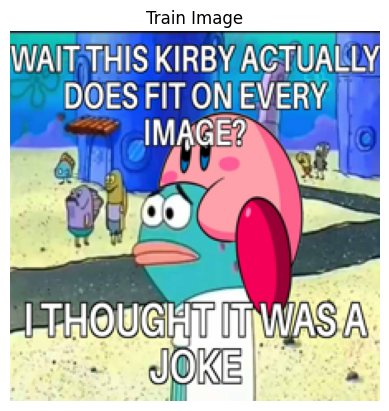

Image Captions: A cartoon fish looks sad as other animated characters around look concerned.
Meme Captions: Meme poster is amused Kirby does fit on any picture.


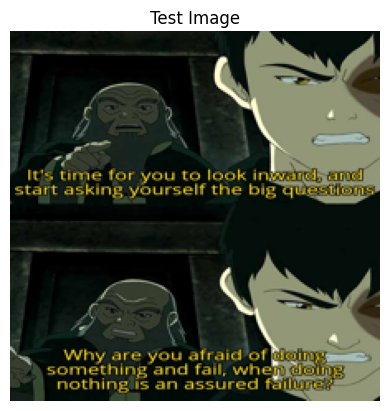

Image Captions: different facial reactions of people in the picture
Meme Captions: None


In [3]:
import matplotlib.pyplot as plt
import random

def display_random_image(df, dataset_type="train"):
    random_index = random.randint(0, len(df) - 1)
    img = df.iloc[random_index]['img']
    img_captions = df.iloc[random_index]['img_captions']
    meme_captions = df.iloc[random_index]['meme_captions'] if 'meme_captions' in df.columns else "Not available"
    
    plt.imshow(img)
    plt.title(f"{dataset_type.capitalize()} Image")
    plt.axis('off')
    plt.show()
    
    print(f"Image Captions: {img_captions}")
    print(f"Meme Captions: {meme_captions}")

# Display a random image and captions from training data
display_random_image(train_df, dataset_type="train")

# Display a random image and captions from test data
display_random_image(test_df, dataset_type="test")


In [32]:

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GRU, Concatenate, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def create_model(vocab_size, max_length):
     # Image input
     image_input = Input(shape=(224, 224, 3))
     resnet = ResNet50(include_top=False, input_tensor=image_input)
     x = GlobalAveragePooling2D()(resnet.output)
    
     # Text input
     text_input = Input(shape=(max_length,))
     y = Embedding(vocab_size, 256)(text_input)
     y = LSTM(256)(y)  # Remove return_sequences=True as we want a single output from LSTM
     y = Dense(256, activation='relu')(y)  # Optional additional dense layer for text processing
    
     # Combine both
     combined = Concatenate()([x, y])
     z = Dense(256, activation='relu')(combined)
     # Adjust the units in the output layer to match max_length and vocab_size
     z = Dense(max_length * vocab_size, activation='softmax')(z)
     z = Reshape((max_length, vocab_size))(z)  # Reshape to match target shape
    
     model = Model(inputs=[image_input, text_input], outputs=z)
     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
     return model
vocab_size = len(tokenizer.word_index) + 1
model = create_model(vocab_size, max_length)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 223,136,780 (851.20 MB)

 Trainable params: 223,083,660 (851.00 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [5]:
# Training the model
history = model.fit(
    [X_train_img, X_train_txt], 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2
)


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1091s 7s/step - accuracy: 0.7718 - loss: 2.8636 - val_accuracy: 0.7959 - val_loss: 1.8006
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1034s 7s/step - accuracy: 0.8052 - loss: 1.7307 - val_accuracy: 0.7953 - val_loss: 1.7856
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1012s 7s/step - accuracy: 0.8063 - loss: 1.7020 - val_accuracy: 0.7959 - val_loss: 1.7825
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1024s 7s/step - accuracy: 0.8053 - loss: 1.6952 - val_accuracy: 0.7959 - val_loss: 1.8102
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1013s 7s/step - accuracy: 0.8071 - loss: 1.6586 - val_accuracy: 0.7957 - val_loss: 1.7515
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1009s 7s/step - accuracy: 0.8079 - loss: 1.6365 - val_accuracy: 0.7959 - val_loss: 1.7484
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1010s 7s/step - accuracy: 0.8068 - loss: 1.6316 - val_accuracy: 0.7959 - val_loss: 1.7357
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1007s 7s/step - accuracy: 0.8084 - loss: 1.6081 - 

In [6]:
# Save the model
model.save('C:/Users/alzae/OneDrive/Desktop/meme-captioning/trained_model.keras')

# Load the model
loaded_model = tf.keras.models.load_model('C:/Users/alzae/OneDrive/Desktop/meme-captioning/trained_model.keras')


In [18]:
def predict_caption(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    preprocessed_txt = preprocess_text("")  # Empty text as we're generating new captions
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)
    preprocessed_txt = np.expand_dims(preprocessed_txt, axis=0)
    print("Input image shape:", preprocessed_img.shape)  # Print input image shape
    print("Input text shape:", preprocessed_txt.shape)  # Print input text shape
    prediction = model.predict([preprocessed_img, preprocessed_txt])
    print("Prediction shape:", prediction.shape)  # Print prediction shape
    return prediction

# Get predictions for all test images
test_predictions = {}
for index, row in test_df.iterrows():
    img_path = os.path.join(image_dir, row['img_fname'])  # Adjust image filename format
    print("Processing image:", img_path)  # Print the image path being processed
    prediction = predict_caption(img_path, model)
    test_predictions[row['img_fname']] = prediction

print(test_predictions)

Processing image: C:/Users/alzae/OneDrive/Desktop/meme-captioning/memes\memes_d079np.png
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
Prediction shape: (1, 68, 11187)
Processing image: C:/Users/alzae/OneDrive/Desktop/meme-captioning/memes\memes_d2rm3s.png
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Prediction shape: (1, 68, 11187)
Processing image: C:/Users/alzae/OneDrive/Desktop/meme-captioning/memes\memes_d9gvok.png
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediction shape: (1, 68, 11187)
Processing image: C:/Users/alzae/OneDrive/Desktop/meme-captioning/memes\memes_eimmhx.png
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Prediction shape: (1, 68, 11187)
Processing image: C:/Users/alzae/OneDrive/Desktop/meme-captioning/memes\memes_er70xq.png
Input image shape: 

In [29]:
# Function to decode predictions and get captions
def decode_predictions(prediction, tokenizer, common_words_weight=1):
    # Define common words
    common_words = ['the', 'is', 'are', 'and', 'to', 'of', 'in', 'a']  # Add more common words as needed
    
    # Convert the prediction to a single sequence of word indices
    predicted_sequence = np.argmax(prediction, axis=-1)[0]
    
    # Convert indices back to words using the tokenizer
    predicted_caption = []
    for idx in predicted_sequence:
        word = tokenizer.index_word.get(idx, '[UNK]')  # Use '[UNK]' for unknown words
        if word == '[PAD]':  # Stop decoding at the padding token
            break
        if word.lower() in common_words:
            # Adjust weight for common words
            adjusted_word = word.lower() if common_words_weight == 1 else f"{word.lower()} ({common_words_weight})"
            predicted_caption.append(adjusted_word)
        else:
            predicted_caption.append(word)
    
    # Join the words to form the caption
    return ' '.join(predicted_caption)

# Get predictions for all test images
test_predictions = {}
for index, row in test_df.iterrows():
    img_path = os.path.join(image_dir, row['img_fname'])   # Adjust image filename format
    prediction = predict_caption(img_path, loaded_model)
    adjusted_caption = decode_predictions(prediction, tokenizer, common_words_weight=0.5)
    test_predictions[row['img_fname']] = prediction
    
# Save remaining predictions to CSV
remaining_predictions = []
for index, row in test_df.iterrows():
    img_fname = row['img_fname']
    post_id = row['post_id']  # Extract post_id from test data
    if img_fname in test_predictions:
        # Decode the prediction
        decoded_caption = decode_predictions(test_predictions[img_fname], tokenizer)
        
        # Append the post_id and predicted caption to the list
        remaining_predictions.append({'post_id': post_id, 'meme_captions': decoded_caption})

# Create a DataFrame from the list of remaining predictions
remaining_predictions_df = pd.DataFrame(remaining_predictions)

# Save the DataFrame to a CSV file
remaining_predictions_df.to_csv('Teamemra.csv', index=False)

print(remaining_predictions_df.head())  # Print a sample of the DataFrame to verify


Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediction shape: (1, 68, 11187)
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediction shape: (1, 68, 11187)
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction shape: (1, 68, 11187)
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction shape: (1, 68, 11187)
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction shape: (1, 68, 11187)
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediction shape: (1, 68, 11187)
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Prediction shape: (1, 68, 11187)
Input image shape: (1, 224, 224, 3)
Input text shape: (1, 68)
1/1 ━